In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random


In [2]:
#np.random.seed(0)
#random.seed(0)

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2051)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance, period_index):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed)
        self.voyage_time = self.time_at_sea + market_instance.port_time   
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand[period_index -1 ], self.capacity)
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time)
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        #self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.main_fuel_con= np.multiply(np.multiply(np.multiply(market_instance.distance, self.ship_energy), np.power(self.operational_speed, 2)) , self.number_of_trips_to_meet_demand)
        self.main_fuel_cons = market_instance.distance * self.ship_energy * (self.operational_speed**2) *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        #self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        return self.aux_fuel_cons 
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        return self.fuel_cost
        
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost 
    
    def get_revenue(self,market_instance, period_index):
        self.revenue = np.multiply(self.firm_demand[period_index - 1], market_instance.freight_rate)
        return self.revenue
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        return self.period_profit
    
    def get_discounted_period_profit(self,market_instance, period_index):
        self.discounted_period_profit = np.multiply( np.power( 1+ market_instance.discount_rate, - period_index), self.period_profit) 
        return self.discounted_period_profit
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  

        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  

        self_carbon_emissions = self_carbon_main_emissions + self_carbon_aux_emissions 
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  

        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  

        self_sulfur_emissions = self_sulfur_main_emissions + self_sulfur_aux_emissions 
        return self_sulfur_emissions

In [6]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]  

#====> Iinitialisation of function objects
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one

#======>
# def generate_chromo(lower_bound:float, upper_bound:float) -> Chromo:
#     return np.random.uniform(lower_bound, upper_bound)

def generate_chromo(lower_bound:float, upper_bound:float, fitness_func: FitnessFunc ) -> Chromo:
    while True:
        chromo = np.random.uniform(lower_bound, upper_bound)   
        if fitness_func(chromo)[0] != 0:
            break
    return chromo  


#======>
# def generate_population(size: int, chromo_lower_bound: float, chromo_upper_bound: float) -> Population: 
#     return np.array([generate_chromo(chromo_lower_bound, chromo_upper_bound) for _ in range(size)])

def generate_population(fitness_func: FitnessFunc, size: int, chromo_lower_bound: float, chromo_upper_bound: float) -> Population: 
    return np.array([generate_chromo(chromo_lower_bound, chromo_upper_bound, fitness_func) for _ in range(size)])

#=====>
def selection_pair (population: Population, fitness_func: FitnessFunc, weights: list):
    return  np.random.choice(np.hstack( population),
                            size = 2, 
                            replace=False,
                            p= weights) 
#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, chromo_lower_bound: float, chromo_upper_bound:float) -> Tuple[Chromo, Chromo]:
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))   
    lower = chromo_lower_bound if lower < chromo_lower_bound else lower
    upper = chromo_upper_bound if upper > chromo_upper_bound else upper
    return np.random.uniform (lower, upper, 2) 

#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float
             , variance: float, probability: float = 0.5 ) -> Chromo: 
        chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
        chromo = chromo_lower_bound if chromo <chromo_lower_bound else chromo
        chromo =chromo_upper_bound if chromo > chromo_upper_bound else chromo
        return chromo

#=====>
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

#=====>
def run_evolution(populate_func: PopulateFunc, 
                  fitness_func: FitnessFunc, 
                  crossover_func: CrossoverFunc,
                  mutation_func: MutationFunc, 
                  generation_limit: int = 1000, 
                  number_of_similarity: int = 50, 
                  selection_func: SelectionFunc = selection_pair) -> Tuple[Population, pd.DataFrame ]:
    """The evolutionnary main loop""" 
    #1. Genrate the 1st generation: Initial generation/population
    population = populate_func(fitness_func)
    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(progress)
    return progress

# 1. Set Up Simulation Parameters:

## * Firm 1:

In [7]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = np.array([10])
max_speed_1 = np.array([30])
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

## * Firm 2:

In [8]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = np.array([10])
max_speed_2 = np.array([30])
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

## * Market :

In [9]:
                    #===========================> Market Attributes <==========================#
number_of_firms = 2
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])

year = np.arange(2016, 2051)
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Initialize Game and Set up firm and market objects 

In [10]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Market Demand

In [11]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652
 1397511.98183639 1455352.28446974 1504050.11466377 1549602.07735933
 1594072.22320876 1638552.17226732 1684273.26074193 1731270.12057536
 1779578.35005746 1829234.54078948 1880276.30540081 1932742.30603904
 1986672.28365504 2042107.08810522 2099088.70909364 2157660.30797763
 2217866.2504608  2279752.14019835 2343364.85334008 2408752.57403719
 2475964.83093995 2545052.53471369 2616068.01660168 2689065.06806397
 2764098.98152235 2841226.59224218 2920506.32138292 3001998.22024985
 3085764.01578064 3171867.15730103 3260372.86458528]
firm 1 market share [0.47717172]
firm 2 market share [0.52282828]


### Graphing Market Demand:

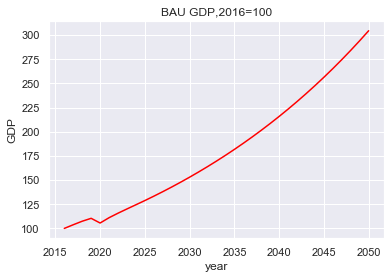

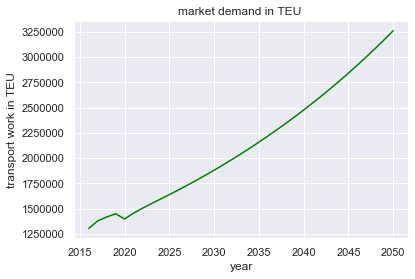

In [12]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



# 4. Compute BAU Pollution Stock

## a. Firm 1:

In [13]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [ 622126.94141414  657835.26161767  676191.06664311  691295.80364566
  666853.19214092  694452.94867021  717690.17592643  739426.28418641
  760646.18004426  781870.75371625  803687.56401464  826113.13632303
  849164.45713853  872858.98693833  897214.6734054   922249.96502307
  947983.82504913  974435.7458797  1001625.76381397 1029574.47423094
 1058303.04718958 1087833.24346435 1118187.43102814 1149388.60199512
 1181460.39003639 1214427.08828156 1248313.66771983 1283145.79611457
 1318949.85744561 1355752.97189415 1393583.01638514 1432468.64570306
 1472439.31419674 1513525.29808991 1555757.71841423]
firm 1 ship energy [0.00053659]


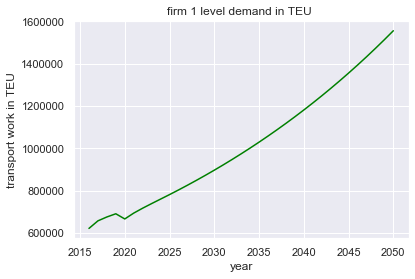

In [14]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

## b. Firm 2

In [15]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)

firm 2 demand [ 681653.05858586  720778.00891894  740890.12721099  757440.11000634
  730658.78969547  760899.33579953  786359.93873734  810175.79317292
  833426.0431645   856681.41855108  880585.6967273   905156.98425233
  930413.89291893  956375.55385115  983061.63199541 1010492.34101596
 1038688.45860591 1067671.34222552 1097462.94527966 1128085.83374669
 1159563.20327122 1191918.89673401 1225177.42231195 1259363.97204207
 1294504.44090355 1330625.44643213 1367754.34888185 1405919.27194941
 1445149.12407673 1485473.62034803 1526923.30499777 1569529.57454679
 1613324.7015839  1658341.85921112 1704615.14617105]
firm 2 ship energy [0.00061541]


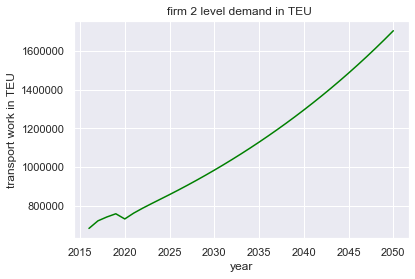

In [16]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

## c. Compute BAU emissions throughout the planning horizon

In [17]:
#Faster method for sovling the problem
# MarketConfig.T = 2
# results = {(my_period_index,"firm" + str(firm_object.index)): 
#            run_evolution(populate_func = partial(generate_population,
#                                                  size=50,
#                                                  chromo_lower_bound = firm_object.min_speed ,
#                                                  chromo_upper_bound = firm_object.max_speed),
#                          fitness_func = partial(fitness,
#                                                 firm = firm_object,
#                                                 sim_game = game_config,
#                                                 max_number_of_vessel = firm_object.max_number_of_vessel,
#                                                 period_index = my_period_index),
#                          generation_limit = 100,
#                          number_of_similarity = 30,
#                          mutation_func = partial (mutation,
#                                                   variance = 0.009,
#                                                   chromo_lower_bound =  firm_object.min_speed,
#                                                   chromo_upper_bound= firm_object.max_speed, 
#                                                   probability = 0.5)
#                         ) 
#            for my_period_index in range(MarketConfig.T)
#            for firm_object in (Firm._registry)}
# results[(1, 'firm1')]

In [18]:
def fitness (chromo: Chromo, 
             firm: Firm, 
             sim_game: MarketConfig, 
             max_number_of_vessel: int, 
             period_index: int) -> Tuple[float, int, float, float]:
    
    operational_speed = firm.update_vessel_speed(chromo)    
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game, period_index)
    number_vessels_sim  = firm.get_number_of_vessel()
    
    if number_vessels_sim > max_number_of_vessel:
        return np.zeros(4) #np.array([-9, -9, -9, -9])
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)        
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        fuel_cost_sim = firm.get_fuel_cost(sim_game)        
        total_cost_sim = firm.get_total_cost()        
        revenues_sim = firm.get_revenue(sim_game, period_index)        
        period_profits_sim = firm.get_period_profits()        
        discounted_period_profits_sim = firm.get_discounted_period_profit(sim_game, period_index)        
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game)        
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        return  discounted_period_profits_sim, number_vessels_sim, carbon_emissions_sim, sulfur_emissions_sim

#===========>
def BAU_emissions_period(p_index):
    """results_period: dict index by firm1, .., firmn contains ganeration vessel speed,
        p_index>= 1,.."""
    results_period = {}
    optimum_solution_period ={}
    carbon_industry_emission_period = 0
    sulfur_industry_emission_period = 0
    for firm_object in (Firm._registry):
        results  = run_evolution(
            populate_func = partial(generate_population,
                                    size=50,
                                    chromo_lower_bound = firm_object.min_speed ,
                                    chromo_upper_bound = firm_object.max_speed),
            fitness_func = partial(fitness,
                                   firm = firm_object,
                                   sim_game = game_config,
                                   max_number_of_vessel = firm_object.max_number_of_vessel,
                                   period_index = my_period_index),
            crossover_func = partial(BLX_alpha_crossover,
                                     chromo_lower_bound= firm_object.min_speed ,
                                     chromo_upper_bound = firm_object.max_speed),
            generation_limit = 100,
            number_of_similarity = 30,
            mutation_func = partial (mutation,
                                     variance = 0.009,
                                     chromo_lower_bound =  firm_object.min_speed,
                                     chromo_upper_bound= firm_object.max_speed,
                                     probability = 0.5))
        results_period["firm" + str(firm_object.index)] = results
        
        # Store Optimum Solution table     
        optimum_solution_period["firm" + str(firm_object.index)] = results_period["firm" + str(firm_object.index)].iloc[[-1]]

        # Compute industry level BAU emissions
        carbon_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Carbon Emissions"].values
        sulfur_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Sulfur Emissions"].values
        #print("carbon_industry_emission_period")
    #print(carbon_industry_emission_period)
    return results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period

In [19]:
#S_1=emissions 
#S_2= E_1^(CO_2 )+(1-δ)   S_1^(CO_2 ) 
#MarketConfig.T = 3
#Get results for period "period"
#BAU_emissions_period(my_period_index +1) Needs to start from 1 till T 
#Results also start from 1 till T 
#========>
BAU_carbon_pollution_stock = np.zeros(MarketConfig.T+1)
BAU_sulfur_pollution_stock = np.zeros(MarketConfig.T+1)
results = {} #empty dict
optimum_solution={} #empty dict 
for my_period_index in range(MarketConfig.T):
    results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period = BAU_emissions_period(my_period_index +1)
    results[my_period_index+1]  = results_period
    optimum_solution [my_period_index +1 ] = optimum_solution_period # a dict ''    
    BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
    BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [15.436261719010409]    [2316429034.455811]            [42.0]   
1           1               14.5233   [2320189106.5956755]            [44.0]   
2           2               14.4347    [2321788485.195819]            [44.0]   
3           3               14.4347    [2321788485.195819]            [44.0]   
4           4               14.4347    [2321788485.195819]            [44.0]   
5           5               13.6252    [2322255941.652157]            [46.0]   
6           6               13.6252    [2322255941.652157]            [46.0]   
7           7               13.6252    [2322255941.652157]            [46.0]   
8           8               13.6252    [2322255941.652157]            [46.0]   
9           9  [14.019393682267621]   [2322349194.1816473]            [45.0]   
10         10  [14.019393682267621]   [2322349194.1816473]            [45.0]   
11         11  [14.019393682267621]   [2

    Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0            0  [14.150884462956821]    [909539060.9438295]            [18.0]   
1            1  [14.150884462956821]    [909539060.9438295]            [18.0]   
2            2  [14.098646257414599]    [909895903.7172388]            [18.0]   
3            3               14.0293    [910366764.8423791]            [18.0]   
4            4               14.0293    [910366764.8423791]            [18.0]   
..         ...                   ...                    ...               ...   
96          96               14.0079    [910511499.0003171]            [18.0]   
97          97               14.0079    [910511499.0003171]            [18.0]   
98          98               14.0079    [910511499.0003171]            [18.0]   
99          99               14.0079    [910511499.0003171]            [18.0]   
100        100               14.0079    [910511499.0003171]            [18.0]   

         Carbon Emissions  

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0   [14.19912095854944]     [952031195.263193]            [20.0]   
1           1  [13.230970161114557]    [952428809.0610526]            [21.0]   
2           2  [13.230970161114557]    [952428809.0610526]            [21.0]   
3           3  [13.230970161114557]    [952428809.0610526]            [21.0]   
4           4  [13.230970161114557]    [952428809.0610526]            [21.0]   
..        ...                   ...                    ...               ...   
70         70                14.009    [953387982.2358745]            [20.0]   
71         71                14.009    [953387982.2358745]            [20.0]   
72         72                14.009    [953387982.2358745]            [20.0]   
73         73                14.009    [953387982.2358745]            [20.0]   
74         74                14.009    [953387982.2358745]            [20.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [13.437797059129435]    [901027570.5754242]            [20.0]   
1           1                13.431    [901070226.0490363]            [20.0]   
2           2                13.431    [901070226.0490363]            [20.0]   
3           3                13.431    [901070226.0490363]            [20.0]   
4           4                13.431    [901070226.0490363]            [20.0]   
..        ...                   ...                    ...               ...   
68         68  [14.294468403334019]     [901499775.289874]            [19.0]   
69         69  [14.294468403334019]     [901499775.289874]            [19.0]   
70         70  [14.294468403334019]     [901499775.289874]            [19.0]   
71         71  [14.294468403334019]     [901499775.289874]            [19.0]   
72         72  [14.294468403334019]     [901499775.289874]            [19.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [12.993665977657717]    [932083668.2950692]            [22.0]   
1           1  [13.855064010083586]    [932367810.8296859]            [21.0]   
2           2  [13.855064010083586]    [932367810.8296859]            [21.0]   
3           3  [13.855064010083586]    [932367810.8296859]            [21.0]   
4           4  [13.855064010083586]    [932367810.8296859]            [21.0]   
5           5  [13.855064010083586]    [932367810.8296859]            [21.0]   
6           6  [13.855064010083586]    [932367810.8296859]            [21.0]   
7           7  [13.855064010083586]    [932367810.8296859]            [21.0]   
8           8  [13.855064010083586]    [932367810.8296859]            [21.0]   
9           9                13.822     [932592142.740391]            [21.0]   
10         10               13.8201    [932605281.9307456]            [21.0]   
11         11               13.8201    [

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0   [14.39503105308174]     [941617918.846265]            [21.0]   
1           1   [14.39503105308174]     [941617918.846265]            [21.0]   
2           2   [14.39503105308174]     [941617918.846265]            [21.0]   
3           3   [14.39503105308174]     [941617918.846265]            [21.0]   
4           4   [14.39503105308174]     [941617918.846265]            [21.0]   
5           5  [13.531426897891405]    [941859808.7094291]            [22.0]   
6           6  [13.531426897891405]    [941859808.7094291]            [22.0]   
7           7  [13.531426897891405]    [941859808.7094291]            [22.0]   
8           8  [13.531426897891405]    [941859808.7094291]            [22.0]   
9           9  [13.531426897891405]    [941859808.7094291]            [22.0]   
10         10               13.5078    [942016651.7782744]            [22.0]   
11         11               13.5078    [

    Generation        Vessel Speed Firm Discounted profit Number of vessels  \
0            0  [13.3520240812948]    [948998079.4675578]            [23.0]   
1            1             14.0608    [949810130.8396245]            [22.0]   
2            2             14.0262    [950055119.8496857]            [22.0]   
3            3             14.0262    [950055119.8496857]            [22.0]   
4            4             14.0262    [950055119.8496857]            [22.0]   
..         ...                 ...                    ...               ...   
96          96             14.0151     [950133136.817784]            [22.0]   
97          97             14.0151     [950133136.817784]            [22.0]   
98          98             14.0151     [950133136.817784]            [22.0]   
99          99             14.0151     [950133136.817784]            [22.0]   
100        100             14.0151     [950133136.817784]            [22.0]   

        Carbon Emissions      Sulfur Emissions  
0 

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [12.310241915811082]   [1059293408.5714281]            [25.0]   
1           1  [12.310241915811082]   [1059293408.5714281]            [25.0]   
2           2               13.7326   [1059745142.0278461]            [23.0]   
3           3               13.7326   [1059745142.0278461]            [23.0]   
4           4               13.7326   [1059745142.0278461]            [23.0]   
..        ...                   ...                    ...               ...   
56         56               12.9704   [1060115587.7756591]            [24.0]   
57         57               12.9704   [1060115587.7756591]            [24.0]   
58         58               12.9704   [1060115587.7756591]            [24.0]   
59         59               12.9704   [1060115587.7756591]            [24.0]   
60         60               12.9704   [1060115587.7756591]            [24.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [14.370839469215671]    [974997051.1740049]            [25.0]   
1           1               14.4706    [979459465.5376124]            [24.0]   
2           2               13.7078    [979828934.9568266]            [25.0]   
3           3               13.7078    [979828934.9568266]            [25.0]   
4           4               13.7078    [979828934.9568266]            [25.0]   
5           5               13.7078    [979828934.9568266]            [25.0]   
6           6               13.7078    [979828934.9568266]            [25.0]   
7           7               13.7078    [979828934.9568266]            [25.0]   
8           8               13.7078    [979828934.9568266]            [25.0]   
9           9               13.7078    [979828934.9568266]            [25.0]   
10         10               13.7078    [979828934.9568266]            [25.0]   
11         11               13.7078    [

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [12.933417511848727]    [986018782.8026984]            [27.0]   
1           1  [12.933417511848727]    [986018782.8026984]            [27.0]   
2           2               13.6654    [986174233.6572866]            [26.0]   
3           3               12.8884    [986310265.7506871]            [27.0]   
4           4               12.8884    [986310265.7506871]            [27.0]   
..        ...                   ...                    ...               ...   
83         83               14.1973    [987426457.6679991]            [25.0]   
84         84               14.1973    [987426457.6679991]            [25.0]   
85         85               14.1973    [987426457.6679991]            [25.0]   
86         86               14.1973    [987426457.6679991]            [25.0]   
87         87               14.1973    [987426457.6679991]            [25.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [12.178368640204226]    [992111973.1495826]            [29.0]   
1           1  [12.866849341222261]    [992855529.1907712]            [28.0]   
2           2               13.9925    [995085620.3602943]            [26.0]   
3           3               13.9925    [995085620.3602943]            [26.0]   
4           4               13.9925    [995085620.3602943]            [26.0]   
5           5               13.9925    [995085620.3602943]            [26.0]   
6           6               13.9925    [995085620.3602943]            [26.0]   
7           7               13.9925    [995085620.3602943]            [26.0]   
8           8               13.9925    [995085620.3602943]            [26.0]   
9           9               13.9925    [995085620.3602943]            [26.0]   
10         10               13.9925    [995085620.3602943]            [26.0]   
11         11               13.9925    [

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0   [13.44553690092491]   [1108087262.7527044]            [28.0]   
1           1  [13.925490111745718]   [1108967635.1336365]            [27.0]   
2           2  [13.925490111745718]   [1108967635.1336365]            [27.0]   
3           3  [12.675329999005733]   [1109224179.7083998]            [29.0]   
4           4   [13.15994925933817]   [1110393677.7834182]            [28.0]   
..        ...                   ...                    ...               ...   
62         62  [13.156713902271543]   [1110419393.6146631]            [28.0]   
63         63  [13.156713902271543]   [1110419393.6146631]            [28.0]   
64         64  [13.156713902271543]   [1110419393.6146631]            [28.0]   
65         65  [13.156713902271543]   [1110419393.6146631]            [28.0]   
66         66  [13.156713902271543]   [1110419393.6146631]            [28.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [12.931733555504684]   [1017618636.1513443]            [30.0]   
1           1  [12.931733555504684]   [1017618636.1513443]            [30.0]   
2           2               14.1455   [1018356878.5298296]            [28.0]   
3           3               14.1455   [1018356878.5298296]            [28.0]   
4           4               14.1455   [1018356878.5298296]            [28.0]   
5           5               14.1455   [1018356878.5298296]            [28.0]   
6           6  [14.135141936097808]   [1018436414.5739472]            [28.0]   
7           7  [14.135141936097808]   [1018436414.5739472]            [28.0]   
8           8  [14.135141936097808]   [1018436414.5739472]            [28.0]   
9           9  [14.135141936097808]   [1018436414.5739472]            [28.0]   
10         10  [14.135141936097808]   [1018436414.5739472]            [28.0]   
11         11  [14.135141936097808]   [1

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [13.394921359515406]   [1033382036.1907791]            [31.0]   
1           1  [13.394921359515406]   [1033382036.1907791]            [31.0]   
2           2               13.9246   [1034010129.7592123]            [30.0]   
3           3               13.9246   [1034010129.7592123]            [30.0]   
4           4               13.9246   [1034010129.7592123]            [30.0]   
..        ...                   ...                    ...               ...   
69         69               13.8791   [1034354945.0619406]            [30.0]   
70         70               13.8791   [1034354945.0619406]            [30.0]   
71         71               13.8791   [1034354945.0619406]            [30.0]   
72         72               13.8791   [1034354945.0619406]            [30.0]   
73         73               13.8791   [1034354945.0619406]            [30.0]   

       Carbon Emissions      Sulfur Emi

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0   [13.38206158578505]   [1152808176.3740158]            [32.0]   
1           1               12.7901   [1153204621.9092445]            [33.0]   
2           2               12.7708   [1153357940.4128046]            [33.0]   
3           3               12.7127   [1153815443.3641765]            [33.0]   
4           4               12.7127   [1153815443.3641765]            [33.0]   
5           5               12.7127   [1153815443.3641765]            [33.0]   
6           6               12.7127   [1153815443.3641765]            [33.0]   
7           7               12.7127   [1153815443.3641765]            [33.0]   
8           8               12.7127   [1153815443.3641765]            [33.0]   
9           9               12.7127   [1153815443.3641765]            [33.0]   
10         10               12.7127   [1153815443.3641765]            [33.0]   
11         11               12.7127   [1

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [13.225023107938473]   [1162601480.4337084]            [33.0]   
1           1  [13.225023107938473]   [1162601480.4337084]            [33.0]   
2           2  [13.225023107938473]   [1162601480.4337084]            [33.0]   
3           3  [13.225023107938473]   [1162601480.4337084]            [33.0]   
4           4               13.1849   [1162937533.8374915]            [33.0]   
..        ...                   ...                    ...               ...   
65         65  [13.170533710407076]   [1163057108.7460504]            [33.0]   
66         66  [13.170533710407076]   [1163057108.7460504]            [33.0]   
67         67  [13.170533710407076]   [1163057108.7460504]            [33.0]   
68         68  [13.170533710407076]   [1163057108.7460504]            [33.0]   
69         69  [13.170533710407076]   [1163057108.7460504]            [33.0]   

       Carbon Emissions      Sulfur Emi

    Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0            0   [13.15713441389054]   [1180707074.6662867]            [35.0]   
1            1   [13.15713441389054]   [1180707074.6662867]            [35.0]   
2            2  [13.614784183640113]    [1180936731.684756]            [34.0]   
3            3  [13.614784183640113]    [1180936731.684756]            [34.0]   
4            4               13.1268   [1180962991.2542346]            [35.0]   
..         ...                   ...                    ...               ...   
96          96  [13.105314471142837]   [1181143865.7220416]            [35.0]   
97          97  [13.105314471142837]   [1181143865.7220416]            [35.0]   
98          98  [13.105314471142837]   [1181143865.7220416]            [35.0]   
99          99  [13.105314471142837]   [1181143865.7220416]            [35.0]   
100        100  [13.105314471142837]   [1181143865.7220416]            [35.0]   

        Carbon Emissions   

   Generation         Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [14.26589226288122]   [1081814929.4357564]            [35.0]   
1           1  [14.26589226288122]   [1081814929.4357564]            [35.0]   
2           2  [13.65536622670362]    [1082660390.197423]            [36.0]   
3           3  [13.65536622670362]    [1082660390.197423]            [36.0]   
4           4  [13.65536622670362]    [1082660390.197423]            [36.0]   
..        ...                  ...                    ...               ...   
91         91              14.0799   [1083334163.1632252]            [35.0]   
92         92              14.0799   [1083334163.1632252]            [35.0]   
93         93              14.0799   [1083334163.1632252]            [35.0]   
94         94              14.0799   [1083334163.1632252]            [35.0]   
95         95              14.0799   [1083334163.1632252]            [35.0]   

       Carbon Emissions      Sulfur Emissions  
0  

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [14.280489715590965]   [1098446544.0876582]            [37.0]   
1           1               13.7693   [1098745840.7711964]            [38.0]   
2           2  [14.603051854562853]   [1099576139.0852468]            [36.0]   
3           3               14.0853    [1100067246.276744]            [37.0]   
4           4               14.0769   [1100135908.9741187]            [37.0]   
5           5               14.0769   [1100135908.9741187]            [37.0]   
6           6               14.0769   [1100135908.9741187]            [37.0]   
7           7               14.0769   [1100135908.9741187]            [37.0]   
8           8               14.0769   [1100135908.9741187]            [37.0]   
9           9               14.0769   [1100135908.9741187]            [37.0]   
10         10               14.0769   [1100135908.9741187]            [37.0]   
11         11               14.0769   [1

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [13.708893049020874]   [1107971535.0943696]            [39.0]   
1           1  [14.167759400817957]    [1108028106.116144]            [38.0]   
2           2  [14.167759400817957]    [1108028106.116144]            [38.0]   
3           3  [14.167759400817957]    [1108028106.116144]            [38.0]   
4           4  [14.094069364926568]   [1108641461.3963952]            [38.0]   
..        ...                   ...                    ...               ...   
95         95  [13.614943719054837]   [1108716006.8374164]            [39.0]   
96         96  [13.614943719054837]   [1108716006.8374164]            [39.0]   
97         97  [13.614943719054837]   [1108716006.8374164]            [39.0]   
98         98  [13.614943719054837]   [1108716006.8374164]            [39.0]   
99         99  [13.614943719054837]   [1108716006.8374164]            [39.0]   

        Carbon Emissions      Sulfur Em

    Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0            0  [14.124370375450274]   [1236163899.9907074]            [39.0]   
1            1               13.6776   [1236716570.1182177]            [40.0]   
2            2               13.6776   [1236716570.1182177]            [40.0]   
3            3               13.6776   [1236716570.1182177]            [40.0]   
4            4               13.6776   [1236716570.1182177]            [40.0]   
..         ...                   ...                    ...               ...   
96          96                13.224   [1237136619.8773062]            [41.0]   
97          97                13.224   [1237136619.8773062]            [41.0]   
98          98                13.224   [1237136619.8773062]            [41.0]   
99          99                13.224   [1237136619.8773062]            [41.0]   
100        100                13.224   [1237136619.8773062]            [41.0]   

        Carbon Emissions   

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0  [13.823818104837093]   [1134261379.1857686]            [42.0]   
1           1                14.216   [1134539911.8112786]            [41.0]   
2           2               14.2102   [1134590230.3672483]            [41.0]   
3           3               14.2102   [1134590230.3672483]            [41.0]   
4           4               14.2102   [1134590230.3672483]            [41.0]   
5           5               14.2102   [1134590230.3672483]            [41.0]   
6           6               14.2102   [1134590230.3672483]            [41.0]   
7           7               14.2102   [1134590230.3672483]            [41.0]   
8           8               14.2102   [1134590230.3672483]            [41.0]   
9           9               14.2102   [1134590230.3672483]            [41.0]   
10         10               14.2102   [1134590230.3672483]            [41.0]   
11         11               14.2102   [1

   Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0           0     [14.399452646044]    [1142233826.447659]            [42.0]   
1           1     [14.399452646044]    [1142233826.447659]            [42.0]   
2           2               14.3089    [1143028958.901711]            [42.0]   
3           3  [13.864390549300316]   [1143315725.4807827]            [43.0]   
4           4  [13.864390549300316]   [1143315725.4807827]            [43.0]   
..        ...                   ...                    ...               ...   
58         58               13.8383   [1143533590.5595474]            [43.0]   
59         59               13.8383   [1143533590.5595474]            [43.0]   
60         60               13.8383   [1143533590.5595474]            [43.0]   
61         61               13.8383   [1143533590.5595474]            [43.0]   
62         62               13.8383   [1143533590.5595474]            [43.0]   

        Carbon Emissions      Sulfur Em

In [20]:
#results[2]["firm1"]

In [21]:
#optimum_solution[2]['firm1']

## Placeholders Analysis: No carbon emissions constraints policy

In [22]:
firms = optimum_solution[1].keys()
periodes = optimum_solution.keys()

##### Discounted Period Profits

In [23]:
Discounted_period_profits = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Discounted_period_profits[firm][periode] = ((optimum_solution[periode][firm]["Firm Discounted profit"]).values).astype(float)
Discounted_period_profits

,firm1,firm2
1,[2322432534.98287],[2571481750.2983284]
2,[910511499.0003171],[1008122554.9170631]
3,[943881797.5325302],[1045104218.3279858]
4,[951184973.2157409],[1053061928.035356]
5,[953387982.2358745],[1055618735.6043922]
6,[901499775.289874],[998313570.6334761]
7,[920377467.8215578],[1019266046.9705582]
8,[932723820.9081638],[1032656027.4394703]
9,[942016651.7782744],[1043053173.6464946]
10,[950133136.817784],[1052026401.8082197]


#####  Vessel Speed

In [24]:
Vessel_speed_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Vessel_speed_optimum[firm][periode] = ((optimum_solution[periode][firm]["Vessel Speed"]).values).astype(float)
Vessel_speed_optimum

,firm1,firm2
1,[14.014557691455863],[13.241890866132277]
2,[14.007870562381008],[13.055648584540092]
3,[14.040350254211235],[13.13205759059023]
4,[13.6098686702319],[13.610216893902894]
5,[14.00903377167844],[13.146017713333427]
6,[14.294468403334019],[13.365931761851897]
7,[14.11422149958723],[13.223964088971195]
8,[13.802604587920754],[12.994680778343001]
9,[13.507766187084204],[13.505803306326909]
10,[14.015121630294878],[13.225283920995237]


#####  Number of vessels

In [25]:
number_of_vessel_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        number_of_vessel_optimum[firm][periode] = ((optimum_solution[periode][firm]["Number of vessels"]).values).astype(float)
number_of_vessel_optimum

,firm1,firm2
1,[45.0],[47.0]
2,[18.0],[19.0]
3,[19.0],[20.0]
4,[20.0],[20.0]
5,[20.0],[21.0]
6,[19.0],[20.0]
7,[20.0],[21.0]
8,[21.0],[22.0]
9,[22.0],[22.0]
10,[22.0],[23.0]


#####  Carbon Emissions Path

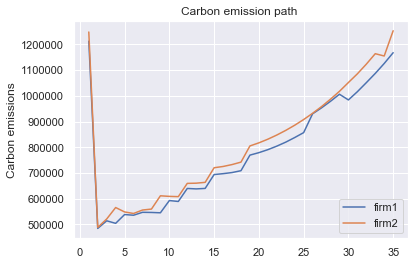

,firm1,firm2
1,[1212511.4611641867],[1248109.571614805]
2,[484514.23893244506],[488579.3372932378]
3,[514139.4352366988],[521162.16327287926]
4,[504214.2211030865],[565726.07868884]
5,[538451.3712517486],[548546.5035930522]
6,[535778.26063481],[542614.2574386282]
7,[547138.9470252029],[555985.913176162]
8,[546561.1557810254],[559704.4513606896]
9,[545232.8438298083],[611330.9721332141]
10,[592861.5073544388],[609072.7471745776]


In [26]:
carbon_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        carbon_emission[firm][periode] = ((optimum_solution[periode][firm]["Carbon Emissions"]).values).astype(float)

carbon_emission.to_csv("carbonemissionpath")


plt.plot(list(range(1,MarketConfig.T+1)),carbon_emission)
plt.title("Carbon emission path " )
plt.ylabel('Carbon emissions')
plt.legend(labels  =carbon_emission.columns.tolist())
plt.show()

carbon_emission

### Sulfur Emission Path


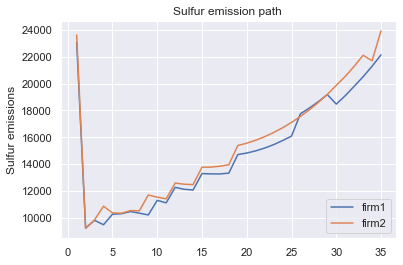

,firm1,firm2
1,[23073.87944082215],[23630.054762266118]
2,[9218.204365116924],[9187.544496180682]
3,[9792.205880308209],[9827.978778000099]
4,[9462.449374451095],[10845.230095971607]
5,[10244.784032332647],[10349.664571957026]
6,[10286.240345660097],[10317.807311215056]
7,[10445.501155931437],[10519.579018755947]
8,[10327.23489282331],[10500.88804688843]
9,[10193.99109983285],[11679.519552684666]
10,[11282.257903024702],[11524.556215850747]


In [27]:
sulfur_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        sulfur_emission[firm][periode] = ((optimum_solution[periode][firm]["Sulfur Emissions"]).values).astype(float)

        
plt.plot(list(range(1,MarketConfig.T+1)),sulfur_emission)
plt.title("Sulfur emission path " )
plt.ylabel('Sulfur emissions')
plt.legend(labels  = sulfur_emission.columns.tolist())
plt.show()



sulfur_emission.to_csv("sulfuremissionpath")
sulfur_emission

#####  Carbon and Sulfur Pollution Stock

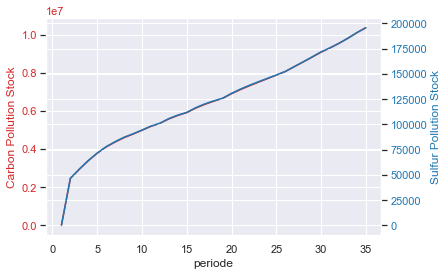

,Carbon Pollution Stock,Sulfur Pollution Stock
1,0,0
2,2.46062e+06,46703.9
3,2.94159e+06,55768.9
4,3.38857e+06,64235.3
5,3.7808e+06,71695.9
6,4.11164e+06,77951.2
7,4.3677e+06,82965
8,4.59729e+06,87337.1
9,4.7841e+06,90697.8
10,4.98384e+06,94431.7


In [28]:
Pollution_Stock = pd.DataFrame(columns = ["Carbon Pollution Stock", "Sulfur Pollution Stock"] ,  index = periodes )

for periode in periodes:
    Pollution_Stock["Carbon Pollution Stock"][periode] = BAU_carbon_pollution_stock[periode -1]
    Pollution_Stock["Sulfur Pollution Stock"][periode] = BAU_sulfur_pollution_stock[periode -1]

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel('Carbon Pollution Stock', color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Carbon Pollution Stock"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sulfur Pollution Stock', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Sulfur Pollution Stock"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Pollution_Stock

#####  Carbon and Sulfur Pollution Damages

In [29]:
sulfur_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
#sulfur_industry_carbon_damages
BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)
#BAU_industry_carbon_damages

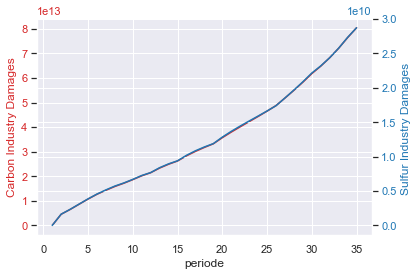

,Carbon Industry Damages,Sulfur Industry Damages
1,0,0
2,4.54099e+12,1.63594e+09
3,6.48972e+12,2.33263e+09
4,8.61182e+12,3.09463e+09
5,1.07208e+13,3.85523e+09
6,1.26792e+13,4.55729e+09
7,1.43076e+13,5.16239e+09
8,1.58513e+13,5.72082e+09
9,1.71657e+13,6.16957e+09
10,1.8629e+13,6.68801e+09


In [30]:
Industry_Damages = pd.DataFrame(columns = ["Carbon Industry Damages", "Sulfur Industry Damages "] ,  index = periodes )

for periode in periodes:
    Industry_Damages["Carbon Industry Damages"][periode] = BAU_industry_carbon_damages[periode-1]
    Industry_Damages["Sulfur Industry Damages "][periode] = sulfur_industry_carbon_damages[periode-1]

    
    
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel("Carbon Industry Damages", color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Carbon Industry Damages"] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Sulfur Industry Damages ", color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Sulfur Industry Damages "] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Industry_Damages

### Evaluatin GA performance

### Profit,   Revenue, Cost CO2 Cost,  SOx Cos in 1 graph as a function of generation ??

### Firm 1, Period 1

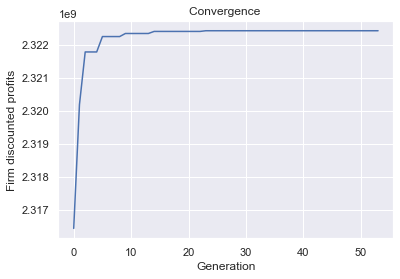

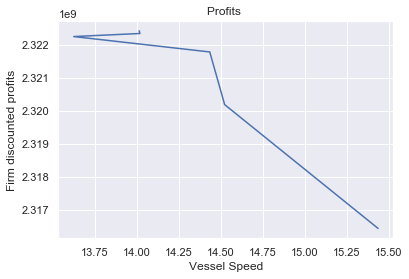

In [31]:
plt.plot(results[1]["firm1"]['Generation'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results[1]["firm1"]['Vessel Speed'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

## Export Results to spreadsheet

In [32]:
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')   
for periode in results.keys():
    for firm in results[periode].keys():
        sheet_name = "period" + str(periode) + firm
        results[periode][firm].to_excel(writer, sheet_name = sheet_name, index =False)
writer.save()

In [33]:
writer_1 = pd.ExcelWriter('optimum_solution.xlsx', engine='xlsxwriter')   
for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sheet_name = "period" + str(periode) + firm
        optimum_solution[periode][firm].to_excel(writer_1, sheet_name = sheet_name, index =False)
writer_1.save()